# mortality

http://dati.istat.it/Index.aspx?DataSetCode=DCIS_MORTALITA1#

In [1]:
import pandasdmx as sdmx
istat = sdmx.Request('ISTAT')

/Users/paolobrasolin/miniconda3/envs/banyan/lib/python3.9/site-packages/pandasdmx/remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


In [2]:
df = sdmx.to_pandas(istat.dataflow().dataflow)
df[df.str.contains('life|death', case=False)]

26_29                                      Deaths
26_295                               Life  tables
29_956    Resident foreigners and life conditions
39_57                    Multiple causes of death
82_87           Aspects of daily life - Household
83_63                       Aspects of daily life
83_85             Aspects of daily life - Persons
dtype: object

In [3]:
lt_msg = istat.dataflow('26_295')
lt_msg.structure

DictLike([('DCIS_MORTALITA1',
           <DataStructureDefinition IT1:DCIS_MORTALITA1(1.0): Life  tables>)])

In [4]:
lt_ds = lt_msg.structure["DCIS_MORTALITA1"]
display(lt_ds.dimensions.components)
#display(lt_ds.attributes.components)
#display(lt_ds.measures.components)

[<Dimension FREQ>,
 <Dimension ETA_CLASSI_ETA>,
 <Dimension ITTER107>,
 <Dimension SESSO>,
 <Dimension FUNZ_BIO>,
 <TimeDimension TIME_PERIOD>]

In [5]:
for component in lt_ds.dimensions.components[:-2]:
    display(component)
    display(sdmx.to_pandas(component.local_representation.enumerated))

funz_bio_component = lt_ds.dimensions.components[-2]
display(funz_bio_component)
opts = sdmx.to_pandas(funz_bio_component.local_representation.enumerated)
display(opts[opts.str.contains('probability', case=False)])

<Dimension FREQ>

CL_FREQ
A                      annual
B    business (not supported)
D                       daily
E       event (not supported)
H                 half-yearly
M                     monthly
Q                   quarterly
W                      weekly
Name: Frequency, dtype: object

<Dimension ETA_CLASSI_ETA>

CL_ETA1
Y_UN3                              until 3 years
Y0-5                                   0-5 years
Y4-CE     4-starting age of compulsory education
Y11-13                               11-13 years
Y6-13                                 6-13 years
                           ...                  
Y35                                     35 years
Y36                                     36 years
Y37                                     37 years
Y38                                     38 years
Y39                                     39 years
Name: Age class, Length: 301, dtype: object

<Dimension ITTER107>

,name,parent
CL_ITTER107,,
IT,Italy,
ITCD,Nord,IT
ITFG,Mezzogiorno,IT
ITF,Sud,IT
ITF1,Abruzzo,ITF
...,...,...
00,Raggruppamento a 107 province,
ITNI,da precisare,
ITNI1,Regioni diverse o non specificate,ITNI


<Dimension SESSO>

CL_SEXISTAT1
3       n.a.
2    females
1      males
9      total
Name: Gender, dtype: object

<Dimension FUNZ_BIO>

CL_TIPO_DATO15
PROBDEATH    probability of death (per thousand) - qx
PROJPROB                  projection probability - Px
Name: Data type 15, dtype: object

In [6]:
key = dict(
    FREQ='A',
    ITTER107='IT',
    FUNZ_BIO='PROJPROB',
    SESSO='9',
    TIME_PERIOD='2015',
)

data_msg = istat.data('26_295', key=key, params=dict(startPeriod='2015',endPeriod='2015'))

In [7]:
data = sdmx.to_pandas(data_msg)
display(data)

FREQ  ETA_CLASSI_ETA  ITTER107  SESSO  FUNZ_BIO  TIME_PERIOD
A     Y0              IT        9      PROJPROB  2015           0.999718
      Y1              IT        9      PROJPROB  2015           0.999814
      Y10             IT        9      PROJPROB  2015           0.999929
      Y10-14          IT        9      PROJPROB  2015           0.999285
      Y100            IT        9      PROJPROB  2015           0.590400
                                                                  ...   
      Y96             IT        9      PROJPROB  2015           0.723578
      Y97             IT        9      PROJPROB  2015           0.683348
      Y98             IT        9      PROJPROB  2015           0.641375
      Y99             IT        9      PROJPROB  2015           0.608418
      Y_UN4           IT        9      PROJPROB  2015           0.999453
Name: value, Length: 144, dtype: float64

In [8]:
d = data.reset_index(level=['ETA_CLASSI_ETA'])
d = d.reset_index(drop=True)
d.columns = ['y', 'p']

d = d[d['y'].str.contains('^Y\d+$')]
d['y'] = d['y'].str[1:].astype(int)
d['p'] = d['p'].apply(lambda x: 1-x)

d = d.sort_values(by='y')
d = d.set_index('y')
display(d)

,p
y,
0,0.000282
1,0.000186
2,0.000143
3,0.000111
4,0.000089
...,...
115,0.815367
116,0.833977
117,0.851037


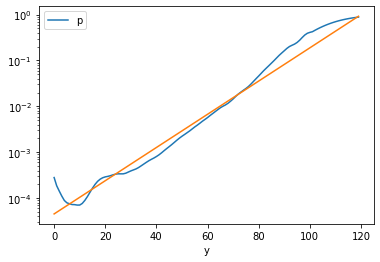

In [14]:
import matplotlib.pyplot as plt
import numpy as np

d.plot()
y = np.arange(120)
plt.plot(y, np.exp(10/120*y-10))
plt.yscale('log')

So, the moral of the story is that $f(x)=e^{10/120*x-10}$ is in the right ballpark for the probability of dying at age $x$.
The numbers mean that nobody gets over $120$ and the probability of dying before the first year is one in $e^{10}\simeq22000$.